In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 22.2 MB/s eta 0:00:00


Make sure you upload the target, feature and index lung numpy files

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, RobustScaler
import json
import optuna
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
import torch.nn.functional as F
import os

os.makedirs('/content/models', exist_ok=True)

model_type = 'lung'

# Load data
features = np.load(f'/content/{model_type}_features.npy')
targets = np.load(f'/content/{model_type}_target.npy')
index = np.load(f'/content/{model_type}_index.npy')

class R2Loss(nn.Module):
    def __init__(self):
        super(R2Loss, self).__init__()

    def forward(self, pred, target):
        target_mean = torch.mean(target)
        ss_tot = torch.sum((target - target_mean) ** 2) + 1e-8
        ss_res = torch.sum((target - pred) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        return -r2
class WeightedR2MSELoss(nn.Module):
    def __init__(self, r2_weight=0.8, mse_weight=0.2, r2_scaling=1.0, mse_scaling=1000000.0):
        super(WeightedR2MSELoss, self).__init__()
        self.r2_weight = r2_weight
        self.mse_weight = mse_weight
        self.r2_scaling = r2_scaling
        self.mse_scaling = mse_scaling

    def forward(self, pred, target):
        mse = torch.mean((pred - target) ** 2)
        target_mean = torch.mean(target)
        ss_tot = torch.sum((target - target_mean) ** 2) + 1e-8
        ss_res = torch.sum((target - pred) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        return -self.r2_weight * self.r2_scaling * r2 + self.mse_weight * self.mse_scaling * mse

class TimeSeries(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, scale_y: bool = True, noise_level=0.0001):
        assert X.shape[0] == y.shape[0], "Mismatched number of samples"

        self.n, self.t, self.f = X.shape
        X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
        self.x_scaler = RobustScaler(quantile_range=(5.0, 95.0))
        X_flat = X.reshape(-1, self.f)
        self.X_scaled = self.x_scaler.fit_transform(X_flat).reshape(self.n, self.t, self.f)
        self.X_scaled = np.clip(self.X_scaled, -10.0, 10.0)
        if noise_level > 0:
            self.X_scaled = self.X_scaled + np.random.normal(0, noise_level, self.X_scaled.shape)

        if np.isnan(self.X_scaled).any():
            print("Warning: NaNs detected in X_scaled after preprocessing")
            self.X_scaled = np.nan_to_num(self.X_scaled, nan=0.0)

        self.scale_y = scale_y
        if y.ndim == 1:
            y = y.reshape(-1, 1)

        y = np.nan_to_num(y, nan=0.0, posinf=1e6, neginf=-1e6)

        if scale_y:
            self.y_scaler = RobustScaler(quantile_range=(5.0, 95.0))
            self.y_scaled = self.y_scaler.fit_transform(y)
            self.y_scaled = np.clip(self.y_scaled, -10.0, 10.0)
        else:
            self.y_scaled = y
            self.y_scaler = None

        if np.isnan(self.y_scaled).any():
            print("Warning: NaNs detected in y_scaled after preprocessing")
            self.y_scaled = np.nan_to_num(self.y_scaled, nan=0.0)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X_scaled[idx], dtype=torch.float32),
            torch.tensor(self.y_scaled[idx], dtype=torch.float32).view(-1)
        )

    def inverse_transform_y(self, y_tensor: torch.Tensor) -> np.ndarray:
        if self.scale_y and self.y_scaler is not None:
            return self.y_scaler.inverse_transform(y_tensor.detach().cpu().numpy())
        else:
            return y_tensor.detach().cpu().numpy()


class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2, bidirectional=False):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        dir_factor = 2 if bidirectional else 1
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * dir_factor, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )
        self.fc1 = nn.Linear(hidden_size * dir_factor, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        if torch.isnan(x).any():
            x = torch.nan_to_num(x, nan=0.0)
        lstm_out, _ = self.lstm(x)

        if torch.isnan(lstm_out).any():
            lstm_out = torch.nan_to_num(lstm_out, nan=0.0)

        attention_weights = self.attention(lstm_out)
        context = torch.sum(attention_weights * lstm_out, dim=1)

        out = self.fc1(context)
        if out.shape[0] > 1:
            out = self.bn1(out)
        out = F.gelu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        if out.shape[0] > 1:
            out = self.bn2(out)
        out = F.gelu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        if torch.isnan(out).any():
            out = torch.nan_to_num(out, nan=0.0)

        return out


class EnsembleModel(nn.Module):
    def __init__(self, models, weights=None):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
        if weights is None:
            self.weights = torch.ones(len(models)) / len(models)
        else:
            total = sum(weights)
            self.weights = torch.tensor([w/total for w in weights])

    def forward(self, x):
        outputs = []
        for i, model in enumerate(self.models):
            outputs.append(model(x))
        ensemble_output = torch.zeros_like(outputs[0])
        for i, output in enumerate(outputs):
            ensemble_output += self.weights[i] * output
        return ensemble_output
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:

def train(model, criterion, optimizer, train_dataloader, scheduler=None):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_dataloader:
        if torch.isnan(batch_X).any() or torch.isnan(batch_y).any():
            batch_X = torch.nan_to_num(batch_X, nan=0.0)
            batch_y = torch.nan_to_num(batch_y, nan=0.0)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()

    if scheduler is not None:
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(epoch_loss / len(train_dataloader))
        else:
            scheduler.step()
    return epoch_loss / len(train_dataloader)


def validate(model, val_dataloader, dataset):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in val_dataloader:
            if torch.isnan(batch_X).any() or torch.isnan(batch_y).any():
                batch_X = torch.nan_to_num(batch_X, nan=0.0)
                batch_y = torch.nan_to_num(batch_y, nan=0.0)
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            if torch.isnan(outputs).any():
                outputs = torch.nan_to_num(outputs, nan=0.0)
            all_targets.append(batch_y.cpu())
            all_preds.append(outputs.cpu())
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    all_preds = torch.nan_to_num(all_preds, nan=0.0)
    all_targets = torch.nan_to_num(all_targets, nan=0.0)
    np_preds = all_preds.numpy()
    np_targets = all_targets.numpy()
    mse = mean_squared_error(np_targets, np_preds)
    r2 = r2_score(np_targets, np_preds)
    try:
        corr = np.corrcoef(np_targets.flatten(), np_preds.flatten())[0, 1]
    except:
        corr = 0.0
    y_pred = dataset.inverse_transform_y(all_preds)
    y_true = dataset.inverse_transform_y(all_targets)
    true_mse = mean_squared_error(y_true, y_pred)
    true_r2 = r2_score(y_true, y_pred)

    return mse, r2, corr, true_mse, true_r2


def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 64, 256, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    bidirectional = trial.suggest_categorical("bidirectional", [True, False])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    r2_weight = trial.suggest_float("r2_weight", 0.5, 0.95)
    mse_weight = 1.0 - r2_weight
    loss_type = trial.suggest_categorical("loss_type", ["r2", "weighted"])

    try:
        X_train, X_test, y_train, y_test = train_test_split(
            features,
            targets,
            test_size=0.2,
            shuffle=True,
            stratify=index[:, 1],
            random_state=42
        )
        train_data = TimeSeries(X_train, y_train, noise_level=0.0001)
        test_data = TimeSeries(X_test, y_test, noise_level=0)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)
        model = AttentionLSTM(
            input_size=features.shape[2],
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            output_size=1,
            bidirectional=bidirectional
        ).to(device)

        if loss_type == "r2":
            criterion = R2Loss()
        else:
            criterion = WeightedR2MSELoss(r2_weight=r2_weight, mse_weight=mse_weight)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)
        epochs = 50
        best_r2 = -float('inf')
        patience = 7
        patience_counter = 0

        for epoch in range(epochs):
            train_loss = train(model, criterion, optimizer, train_loader, scheduler)
            _, r2, _, _, _ = validate(model, test_loader, test_data)
            if r2 > best_r2:
                best_r2 = r2
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break
        _, final_r2, _, true_mse, true_r2 = validate(model, test_loader, test_data)
        trial.report(true_r2, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Baseline values to compare against
        baseline_mse = 0.00000011
        baseline_r2 = 0.75
        if true_r2 < baseline_r2:
            return true_r2
        mse_factor = true_mse / baseline_mse
        if mse_factor > 10:
            penalty = 0.05 * (mse_factor / 10)
            return true_r2 - min(penalty, 0.1)

        return true_r2

    except Exception as e:
        print(f"Trial failed with error: {e}")
        return 0.0

study = optuna.create_study(direction="maximize",
                           pruner=optuna.pruners.MedianPruner(n_startup_trials=5))
study.optimize(objective, n_trials=50)

print("Best trial:")
print(f"R² Score: {study.best_trial.value}")
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")
with open(f'/content/models/{model_type}_r2_optimized_params.json', 'w') as file:
    json.dump(study.best_trial.params, file)
params = study.best_trial.params
hidden_size = params['hidden_size']
num_layers = params['num_layers']
dropout = params['dropout']
learning_rate = params['learning_rate']
batch_size = params['batch_size']
bidirectional = params['bidirectional']
weight_decay = params['weight_decay']
loss_type = params['loss_type']
if 'r2_weight' in params:
    r2_weight = params['r2_weight']
    mse_weight = 1.0 - r2_weight
else:
    r2_weight = 0.8
    mse_weight = 0.2
X_train, X_test, y_train, y_test, _, index_test = train_test_split(
    features,
    targets,
    index,
    test_size=0.2,
    shuffle=True,
    stratify=index[:, 1],
    random_state=42
)
train_data = TimeSeries(X_train, y_train, noise_level=0.0001)
test_data = TimeSeries(X_test, y_test, noise_level=0)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
models = []
for i in range(3):
    h_size = int(hidden_size * (0.9 + 0.2 * np.random.random()))
    d_out = dropout * (0.8 + 0.4 * np.random.random())

    model = AttentionLSTM(
        input_size=features.shape[2],
        hidden_size=h_size,
        num_layers=num_layers,
        dropout=d_out,
        output_size=1,
        bidirectional=bidirectional
    ).to(device)

    models.append(model)
ensemble_model = EnsembleModel(models, weights=[0.5, 0.3, 0.2]).to(device)

if loss_type == "r2":
    criterion = R2Loss()
else:
    criterion = WeightedR2MSELoss(r2_weight=r2_weight, mse_weight=mse_weight)
optimizer = optim.AdamW(ensemble_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler1 = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10, verbose=True, min_lr=1e-6)
scheduler2 = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=learning_rate/20)
num_epochs = 150
best_r2 = -float('inf')
best_model_state = None
patience = 25
patience_counter = 0

train_losses = []
val_mses = []
val_r2s = []
val_corrs = []

for epoch in tqdm(range(num_epochs)):
    train_loss = train(ensemble_model, criterion, optimizer, train_loader)
    scheduler2.step()
    mse, r2, corr, true_mse, true_r2 = validate(ensemble_model, test_loader, test_data)
    scheduler1.step(train_loss)
    train_losses.append(train_loss)
    val_mses.append(true_mse)
    val_r2s.append(true_r2)
    val_corrs.append(corr)
    if true_r2 > best_r2:
        best_r2 = true_r2
        best_model_state = {
            'ensemble': ensemble_model.state_dict(),
            'models': [model.state_dict() for model in models]
        }
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.7f}, "
              f"Val MSE: {true_mse:.8f}, Val R²: {true_r2:.7f}, Val Corr: {corr:.7f}")
if best_model_state:
    ensemble_model.load_state_dict(best_model_state['ensemble'])
    for i, model_state in enumerate(best_model_state['models']):
        models[i].load_state_dict(model_state)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(val_mses)
plt.title('Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.subplot(2, 2, 3)
plt.plot(val_r2s)
plt.title('Validation R²')
plt.xlabel('Epoch')
plt.ylabel('R²')

plt.subplot(2, 2, 4)
plt.plot(val_corrs)
plt.title('Validation Correlation')
plt.xlabel('Epoch')
plt.ylabel('Correlation')

plt.tight_layout()
plt.savefig(f'/content/models/{model_type}_r2_optimized_training_curves.png')
plt.close()

ensemble_model.eval()
predictions = []
targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = ensemble_model(X_batch).cpu()
        predictions.append(outputs)
        targets.append(y_batch)

y_pred_tensor = torch.cat(predictions)
y_true_tensor = torch.cat(targets)

y_pred = test_data.inverse_transform_y(y_pred_tensor)
y_true = test_data.inverse_transform_y(y_true_tensor)

df = pd.DataFrame(index_test, columns=["state", "year"])
df['year'] = df['year'].astype(int)
df["y_true"] = y_true.flatten()
df["y_pred"] = y_pred.flatten()

yg = df.sort_values('year').groupby('year')[['y_true', 'y_pred']].mean().reset_index()

final_mse = mean_squared_error(y_true, y_pred)
final_r2 = r2_score(y_true, y_pred)
final_corr = np.corrcoef(y_true.flatten(), y_pred.flatten())[0, 1]

print(f"Final Test MSE: {final_mse:.8f}")
print(f"Final Test R²: {final_r2:.7f}")
print(f"Final Test Correlation: {final_corr:.4f}")

fig = go.Figure()

fig.add_scatter(x=yg["year"], y=yg["y_pred"], mode="markers+lines", name="Predictions",
                marker=dict(symbol="x", size=10))
fig.add_scatter(x=yg["year"], y=yg["y_true"], mode="markers+lines", name="Ground Truth",
                marker=dict(size=8))

yearly_r2 = r2_score(yg["y_true"], yg["y_pred"])
yearly_corr = np.corrcoef(yg["y_true"], yg["y_pred"])[0, 1]

fig.update_layout(
    title=f"{model_type.capitalize()} Cancer Model (R² Optimized) - Yearly Average (R² = {yearly_r2:.3f}, Corr = {yearly_corr:.3f})",
    xaxis_title="Year",
    yaxis_title="Value",
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.write_html(f'/content/models/{model_type}_r2_optimized_yearly_predictions.html')

fig2 = go.Figure()

fig2.add_scatter(x=y_true.flatten(), y=y_pred.flatten(), mode="markers",
                marker=dict(size=8, opacity=0.6))

max_val = max(np.max(y_true), np.max(y_pred))
min_val = min(np.min(y_true), np.min(y_pred))
fig2.add_scatter(x=[min_val, max_val], y=[min_val, max_val], mode="lines",
                name="Perfect Prediction", line=dict(dash="dash", color="gray"))

fig2.update_layout(
    title=f"{model_type.capitalize()} Cancer Model (R² Optimized) - Predictions vs Ground Truth (R² = {final_r2:.7f}, MSE = {final_mse:.8f})",
    xaxis_title="Ground Truth",
    yaxis_title="Prediction",
    template="plotly_white"
)

fig2.write_html(f'/content/models/{model_type}_r2_optimized_scatter_predictions.html')

torch.save({
    'ensemble': ensemble_model.state_dict(),
    'models': [model.state_dict() for model in models],
    'params': params
}, f"/content/models/{model_type}_r2_optimized_model.pth")

# ----------------
# Two-Stage Training Approach
# ----------------

print("\nStarting two-stage training approach...")
base_model = AttentionLSTM(
    input_size=features.shape[2],
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
    output_size=1,
    bidirectional=bidirectional
).to(device)
stage1_criterion = nn.MSELoss()
stage1_optimizer = optim.Adam(base_model.parameters(), lr=learning_rate, weight_decay=weight_decay/10)
stage1_scheduler = ReduceLROnPlateau(stage1_optimizer, mode='min', factor=0.5, patience=5)
print("Stage 1: MSE Optimization")
stage1_epochs = 50
best_mse = float('inf')
best_stage1_state = None
patience_counter = 0

for epoch in range(stage1_epochs):
    train_loss = train(base_model, stage1_criterion, stage1_optimizer, train_loader, stage1_scheduler)
    mse, r2, _, _, _ = validate(base_model, test_loader, test_data)
    if mse < best_mse:
        best_mse = mse
        best_stage1_state = base_model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 10:
            print(f"Early stopping stage 1 at epoch {epoch+1}")
            break

    if (epoch + 1) % 10 == 0:
        print(f"Stage 1 - Epoch {epoch+1}/{stage1_epochs}, Train Loss: {train_loss:.7f}, Val MSE: {mse:.8f}, Val R²: {r2:.7f}")
base_model.load_state_dict(best_stage1_state)
print("\nStage 2: R² Optimization")
for name, param in base_model.named_parameters():
    if 'lstm' in name or 'fc1' in name:
        param.requires_grad = False

stage2_criterion = R2Loss()
stage2_optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, base_model.parameters()),
    lr=learning_rate / 5,
    weight_decay=weight_decay / 2
)
stage2_scheduler = CosineAnnealingWarmRestarts(stage2_optimizer, T_0=5, T_mult=2, eta_min=1e-6)

stage2_epochs = 50
best_r2 = -float('inf')
best_stage2_state = None
patience_counter = 0

for epoch in range(stage2_epochs):
    train_loss = train(base_model, stage2_criterion, stage2_optimizer, train_loader, stage2_scheduler)
    _, r2, _, true_mse, true_r2 = validate(base_model, test_loader, test_data)

    if true_r2 > best_r2:
        best_r2 = true_r2
        best_stage2_state = base_model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 15:
            print(f"Early stopping stage 2 at epoch {epoch+1}")
            break

    if (epoch + 1) % 5 == 0:
        print(f"Stage 2 - Epoch {epoch+1}/{stage2_epochs}, Train Loss: {train_loss:.7f}, Val R²: {true_r2:.7f}, Val MSE: {true_mse:.8f}")

base_model.load_state_dict(best_stage2_state)

_, _, _, two_stage_mse, two_stage_r2 = validate(base_model, test_loader, test_data)

print("\nTwo-Stage Model Results:")
print(f"MSE: {two_stage_mse:.8f}")
print(f"R²: {two_stage_r2:.7f}")

torch.save(base_model.state_dict(), f"/content/models/{model_type}_two_stage_model.pth")

# ----------------
# Trend-focused Model
# ----------------

print("\nTraining trend-focused model...")
class TrendDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, scale_y: bool = True):
        assert X.shape[0] == y.shape[0], "Mismatched number of samples"
        self.original_X = X
        self.original_y = y.reshape(-1, 1) if y.ndim == 1 else y
        self.x_scaler = RobustScaler(quantile_range=(5.0, 95.0))
        X_flat = np.nan_to_num(X.reshape(-1, X.shape[2]), nan=0.0)
        X_scaled = self.x_scaler.fit_transform(X_flat).reshape(X.shape)
        X_scaled = np.clip(X_scaled, -10.0, 10.0)
        self.n, self.t, self.f = X.shape
        self.features = []
        self.targets = []
        self.indices = []
        for i in range(self.n):
            x_sample = X_scaled[i]
            y_sample = y[i]
            if np.isnan(x_sample).any() or np.isnan(y_sample):
                continue
            if self.t > 1:
                x_pct_change = np.zeros((self.t-1, self.f))
                for j in range(self.t-1):
                    denom = np.abs(x_sample[j]) + 1e-8
                    x_pct_change[j] = (x_sample[j+1] - x_sample[j]) / denom
                x_pct_change = np.clip(x_pct_change, -10.0, 10.0)
                x_combined = np.column_stack([
                    x_pct_change.reshape(-1),
                    x_sample[:-1].reshape(-1)
                ])

                self.features.append(x_combined)
                self.targets.append(y_sample)
                self.indices.append(i)

        if len(self.features) > 0:
            self.features = np.array(self.features)
            self.targets = np.array(self.targets).reshape(-1, 1)
            self.indices = np.array(self.indices)
            self.scale_y = scale_y
            if scale_y:
                self.y_scaler = RobustScaler(quantile_range=(5.0, 95.0))
                self.targets_scaled = self.y_scaler.fit_transform(self.targets)
                self.targets_scaled = np.clip(self.targets_scaled, -10.0, 10.0)
            else:
                self.targets_scaled = self.targets
                self.y_scaler = None
        else:
            print("Warning: No valid samples found for trend dataset")
            self.features = np.zeros((1, 1, self.f * 2))
            self.targets = np.zeros((1, 1))
            self.targets_scaled = np.zeros((1, 1))
            self.indices = np.zeros(1)
            self.scale_y = scale_y
            self.y_scaler = None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.features[idx], dtype=torch.float32),
            torch.tensor(self.targets_scaled[idx], dtype=torch.float32).view(-1)
        )

    def inverse_transform_y(self, y_tensor: torch.Tensor) -> np.ndarray:
        if self.scale_y and self.y_scaler is not None:
            return self.y_scaler.inverse_transform(y_tensor.detach().cpu().numpy())
        else:
            return y_tensor.detach().cpu().numpy()
class TrendModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2):
        super(TrendModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)

        self.fc3 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn3 = nn.BatchNorm1d(hidden_size // 2)

        self.fc4 = nn.Linear(hidden_size // 2, output_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size = x.size(0)
        if torch.isnan(x).any():
            x = torch.nan_to_num(x, nan=0.0)
        if x.dim() > 2:
            x = x.reshape(batch_size, -1)
        x = self.fc1(x)
        if batch_size > 1:
            x = self.bn1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        identity = x
        x = self.fc2(x)
        if batch_size > 1:
            x = self.bn2(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = x + identity
        x = self.fc3(x)
        if batch_size > 1:
            x = self.bn3(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        if torch.isnan(x).any():
            x = torch.nan_to_num(x, nan=0.0)

        return x
trend_train_data = TrendDataset(X_train, y_train)
trend_test_data = TrendDataset(X_test, y_test)
input_dim = trend_train_data.features.shape[1] * trend_train_data.features.shape[2]
trend_train_loader = DataLoader(trend_train_data, batch_size=32, shuffle=True, num_workers=2)
trend_test_loader = DataLoader(trend_test_data, batch_size=32, shuffle=False, num_workers=2)
trend_model = TrendModel(
    input_size=input_dim,
    hidden_size=128,
    output_size=1,
    dropout=0.2
).to(device)
trend_criterion = R2Loss()
trend_optimizer = optim.AdamW(trend_model.parameters(), lr=0.001, weight_decay=1e-5)
trend_scheduler = ReduceLROnPlateau(trend_optimizer, mode='min', factor=0.5, patience=10, verbose=True)
trend_epochs = 100
best_trend_r2 = -float('inf')
best_trend_state = None
patience = 20
patience_counter = 0
print("\nTraining trend-focused model...")
for epoch in range(trend_epochs):
    train_loss = train(trend_model, trend_criterion, trend_optimizer, trend_train_loader, trend_scheduler)
    _, r2, _, true_mse, true_r2 = validate(trend_model, trend_test_loader, trend_test_data)

    if true_r2 > best_trend_r2:
        best_trend_r2 = true_r2
        best_trend_state = trend_model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping trend model at epoch {epoch+1}")
            break
    if (epoch + 1) % 10 == 0:
        print(f"Trend Model - Epoch {epoch+1}/{trend_epochs}, Train Loss: {train_loss:.7f}, "
              f"Val R²: {true_r2:.7f}, Val MSE: {true_mse:.8f}")

trend_model.load_state_dict(best_trend_state)
_, _, _, trend_mse, trend_r2 = validate(trend_model, trend_test_loader, trend_test_data)

print("\nTrend Model Results:")
print(f"MSE: {trend_mse:.8f}")
print(f"R²: {trend_r2:.7f}")

torch.save(trend_model.state_dict(), f"/content/models/{model_type}_trend_model.pth")

# ----------------
# Ultra Ensemble - Final Solution
# ----------------

print("\nCreating ultra ensemble solution...")
def ultra_ensemble_predict(X_batch, weights=None):
    """
    Combines predictions from all three model approaches:
    1. Ensemble LSTM model
    2. Two-stage model
    3. Trend model

    Returns weighted average of predictions
    """
    if weights is None:
        weights = [0.5, 0.3, 0.2]
    X_batch = X_batch.to(device)
    ensemble_model.eval()
    with torch.no_grad():
        ensemble_pred = ensemble_model(X_batch).cpu()
    base_model.eval()
    with torch.no_grad():
        two_stage_pred = base_model(X_batch).cpu()
    X_np = X_batch.cpu().numpy()
    n, t, f = X_np.shape
    trend_features = []

    for i in range(n):
        x_sample = X_np[i]
        if t > 1:
            x_pct_change = np.zeros((t-1, f))
            for j in range(t-1):
                denom = np.abs(x_sample[j]) + 1e-8
                x_pct_change[j] = (x_sample[j+1] - x_sample[j]) / denom
            x_pct_change = np.clip(x_pct_change, -10.0, 10.0)
            x_combined = np.column_stack([
                x_pct_change.reshape(-1),
                x_sample[:-1].reshape(-1)
            ])

            trend_features.append(x_combined)
    if trend_features:
        trend_features = torch.tensor(np.array(trend_features), dtype=torch.float32).to(device)
        trend_model.eval()
        with torch.no_grad():
            trend_pred = trend_model(trend_features).cpu()
    else:
        trend_pred = (ensemble_pred + two_stage_pred) / 2
    final_pred = (
        weights[0] * ensemble_pred +
        weights[1] * two_stage_pred +
        weights[2] * trend_pred
    )

    return final_pred

weight_options = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
best_weights = None
best_ultra_r2 = -float('inf')

print("Optimizing ultra ensemble weights...")
for w1 in weight_options:
    for w2 in weight_options:
        for w3 in weight_options:
            if abs(w1 + w2 + w3 - 1.0) > 1e-6:
                continue

            weights = [w1, w2, w3]

            all_preds = []
            all_targets = []

            for X_batch, y_batch in test_loader:
                pred = ultra_ensemble_predict(X_batch, weights)
                all_preds.append(pred)
                all_targets.append(y_batch)

            y_pred_tensor = torch.cat(all_preds)
            y_true_tensor = torch.cat(all_targets)

            y_pred = test_data.inverse_transform_y(y_pred_tensor)
            y_true = test_data.inverse_transform_y(y_true_tensor)

            ultra_r2 = r2_score(y_true, y_pred)

            if ultra_r2 > best_ultra_r2:
                best_ultra_r2 = ultra_r2
                best_weights = weights

                ultra_mse = mean_squared_error(y_true, y_pred)

                print(f"New best weights: {weights} - R²: {ultra_r2:.7f}, MSE: {ultra_mse:.8f}")

print(f"\nFinal ultra ensemble with weights: {best_weights}")

all_preds = []
all_targets = []

for X_batch, y_batch in test_loader:
    pred = ultra_ensemble_predict(X_batch, best_weights)
    all_preds.append(pred)
    all_targets.append(y_batch)

y_pred_tensor = torch.cat(all_preds)
y_true_tensor = torch.cat(all_targets)

y_pred = test_data.inverse_transform_y(y_pred_tensor)
y_true = test_data.inverse_transform_y(y_true_tensor)

ultra_mse = mean_squared_error(y_true, y_pred)
ultra_r2 = r2_score(y_true, y_pred)
ultra_corr = np.corrcoef(y_true.flatten(), y_pred.flatten())[0, 1]

print("\nUltra Ensemble Final Results:")
print(f"MSE: {ultra_mse:.8f}")
print(f"R²: {ultra_r2:.7f}")
print(f"Correlation: {ultra_corr:.4f}")

df_ultra = pd.DataFrame(index_test, columns=["state", "year"])
df_ultra['year'] = df_ultra['year'].astype(int)
df_ultra["y_true"] = y_true.flatten()
df_ultra["y_pred"] = y_pred.flatten()
yg_ultra = df_ultra.sort_values('year').groupby('year')[['y_true', 'y_pred']].mean().reset_index()
yearly_ultra_r2 = r2_score(yg_ultra["y_true"], yg_ultra["y_pred"])
yearly_ultra_corr = np.corrcoef(yg_ultra["y_true"], yg_ultra["y_pred"])[0, 1]
fig_ultra = go.Figure()

fig_ultra.add_scatter(x=yg_ultra["year"], y=yg_ultra["y_pred"], mode="markers+lines", name="Predictions",
                marker=dict(symbol="x", size=10))
fig_ultra.add_scatter(x=yg_ultra["year"], y=yg_ultra["y_true"], mode="markers+lines", name="Ground Truth",
                marker=dict(size=8))

fig_ultra.update_layout(
    title=f"{model_type.capitalize()} Cancer Model (Ultra Ensemble) - Yearly Average (R² = {yearly_ultra_r2:.3f}, Corr = {yearly_ultra_corr:.3f})",
    xaxis_title="Year",
    yaxis_title="Value",
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig_ultra.write_html(f'/content/models/{model_type}_ultra_ensemble_yearly_predictions.html')
fig_ultra2 = go.Figure()

fig_ultra2.add_scatter(x=y_true.flatten(), y=y_pred.flatten(), mode="markers",
                marker=dict(size=8, opacity=0.6))

max_val = max(np.max(y_true), np.max(y_pred))
min_val = min(np.min(y_true), np.min(y_pred))
fig_ultra2.add_scatter(x=[min_val, max_val], y=[min_val, max_val], mode="lines",
                name="Perfect Prediction", line=dict(dash="dash", color="gray"))

fig_ultra2.update_layout(
    title=f"{model_type.capitalize()} Cancer Model (Ultra Ensemble) - Predictions vs Ground Truth (R² = {ultra_r2:.7f}, MSE: {ultra_mse:.8f})",
    xaxis_title="Ground Truth",
    yaxis_title="Prediction",
    template="plotly_white"
)

fig_ultra2.write_html(f'/content/models/{model_type}_ultra_ensemble_scatter_predictions.html')
torch.save({
    'ensemble_model': ensemble_model.state_dict(),
    'two_stage_model': base_model.state_dict(),
    'trend_model': trend_model.state_dict(),
    'weights': best_weights,
    'params': params
}, f"/content/models/{model_type}_ultra_ensemble_model.pth")


print("\n=== FINAL MODEL COMPARISON ===")
print(f"Ensemble model:     R² = {final_r2:.7f}, MSE = {final_mse:.8f}")
print(f"Two-stage model:    R² = {two_stage_r2:.7f}, MSE = {two_stage_mse:.8f}")
print(f"Trend model:        R² = {trend_r2:.7f}, MSE = {trend_mse:.8f}")
print(f"Ultra ensemble:     R² = {ultra_r2:.7f}, MSE = {ultra_mse:.8f}")
print("============================")

[I 2025-06-02 04:52:22,226] A new study created in memory with name: no-name-402a43e8-b717-4b7f-8005-a6eb89ad9a05
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:52:37,974] Trial 0 finished with value: -0.1083906888961792 and parameters: {'hidden_size': 192, 'num_layers': 1, 'dropout': 0.2587089712391521, 'learning_rate': 1.1698468405447967e-05, 'batch_size': 8, 'bidirectional': True, 'weight_decay': 3.277311711633485e-06, 'r2_weight': 0.5224463846656838, 'loss_type': 'r2'}. Best is trial 0 with value: -0.1083906888961792.
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:52:43,165] Trial 1 finished with value: 0.32713329792022705 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.46

Trial failed with error: 


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:53:47,429] Trial 12 finished with value: 0.1915065050125122 and parameters: {'hidden_size': 160, 'num_layers': 3, 'dropout': 0.30816772380478213, 'learning_rate': 0.0023296217023666397, 'batch_size': 64, 'bidirectional': True, 'weight_decay': 4.044711313804676e-06, 'r2_weight': 0.7130930048317737, 'loss_type': 'weighted'}. Best is trial 7 with value: 0.421409010887146.
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:53:51,191] Trial 13 finished with value: 0.28707611560821533 and parameters: {'hidden_size': 160, 'num_layers': 3, 'dropout': 0.4278842041460251, 'learning_rate': 0.004132148721589339, 'batch_size': 64, 'bidirectional': True, 'weight_deca

Trial failed with error: 


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:54:49,936] Trial 20 finished with value: 0.08761787414550781 and parameters: {'hidden_size': 224, 'num_layers': 2, 'dropout': 0.11358195836187299, 'learning_rate': 2.4100625677984046e-05, 'batch_size': 16, 'bidirectional': False, 'weight_decay': 0.0007870756880750218, 'r2_weight': 0.6720412256806615, 'loss_type': 'r2'}. Best is trial 7 with value: 0.421409010887146.
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:55:02,246] Trial 21 finished with value: 0.4137052893638611 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.04643016664928637, 'learning_rate': 0.007924401118183993, 'batch_size': 16, 'bidirectional': True, 'weight_decay':

Trial failed with error: 


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:55:37,341] Trial 27 finished with value: 0.36294108629226685 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.133750635029526, 'learning_rate': 0.006091722897514577, 'batch_size': 16, 'bidirectional': True, 'weight_decay': 6.995230648657394e-05, 'r2_weight': 0.5956488338587224, 'loss_type': 'r2'}. Best is trial 7 with value: 0.421409010887146.
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:55:49,286] Trial 28 finished with value: 0.41988134384155273 and parameters: {'hidden_size': 160, 'num_layers': 2, 'dropout': 0.03159401780567, 'learning_rate': 0.0010307435172193374, 'batch_size': 8, 'bidirectional': False, 'weight_decay': 0.000

Trial failed with error: 


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:56:31,843] Trial 31 finished with value: 0.163937509059906 and parameters: {'hidden_size': 192, 'num_layers': 2, 'dropout': 0.00822508814583385, 'learning_rate': 0.00016238532933395418, 'batch_size': 8, 'bidirectional': False, 'weight_decay': 0.0006284537444947562, 'r2_weight': 0.5013535516954861, 'loss_type': 'r2'}. Best is trial 7 with value: 0.421409010887146.
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:56:53,498] Trial 32 finished with value: 0.4693928360939026 and parameters: {'hidden_size': 160, 'num_layers': 2, 'dropout': 0.031836289148041416, 'learning_rate': 0.001373724419481818, 'batch_size': 8, 'bidirectional': False, 'weight_decay': 0

Trial failed with error: 


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:57:23,705] Trial 34 finished with value: 0.0 and parameters: {'hidden_size': 224, 'num_layers': 2, 'dropout': 0.03909190968487353, 'learning_rate': 0.0004167424383947507, 'batch_size': 8, 'bidirectional': False, 'weight_decay': 0.00017343641929185865, 'r2_weight': 0.6170306723023902, 'loss_type': 'r2'}. Best is trial 32 with value: 0.4693928360939026.


Trial failed with error: 


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:57:38,713] Trial 35 finished with value: 0.3616750240325928 and parameters: {'hidden_size': 192, 'num_layers': 2, 'dropout': 0.0769998176309814, 'learning_rate': 0.001717326756231158, 'batch_size': 8, 'bidirectional': False, 'weight_decay': 0.0009122287723190203, 'r2_weight': 0.5812940350693258, 'loss_type': 'r2'}. Best is trial 32 with value: 0.4693928360939026.
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:57:43,178] Trial 36 finished with value: 0.332439661026001 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.03088403417613862, 'learning_rate': 0.0006734183369542106, 'batch_size': 32, 'bidirectional': False, 'weight_decay': 1

Trial failed with error: 


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:58:14,215] Trial 38 finished with value: 0.0 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.2475598499143948, 'learning_rate': 0.00010039648122986246, 'batch_size': 8, 'bidirectional': False, 'weight_decay': 5.216808844020266e-05, 'r2_weight': 0.5290632287416404, 'loss_type': 'r2'}. Best is trial 32 with value: 0.4693928360939026.


Trial failed with error: 


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:58:22,878] Trial 39 finished with value: 0.45863622426986694 and parameters: {'hidden_size': 192, 'num_layers': 2, 'dropout': 0.09523012855531658, 'learning_rate': 0.002319607463363223, 'batch_size': 32, 'bidirectional': False, 'weight_decay': 1.723879146723707e-05, 'r2_weight': 0.74627356339759, 'loss_type': 'weighted'}. Best is trial 32 with value: 0.4693928360939026.
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:58:28,962] Trial 40 finished with value: 0.4507269263267517 and parameters: {'hidden_size': 224, 'num_layers': 3, 'dropout': 0.09666662700893162, 'learning_rate': 0.0008915865916102976, 'batch_size': 32, 'bidirectional': False, 'weight_d

Trial failed with error: 


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:58:47,592] Trial 43 finished with value: 0.4597788453102112 and parameters: {'hidden_size': 192, 'num_layers': 3, 'dropout': 0.0650323019573874, 'learning_rate': 0.0005048077094805545, 'batch_size': 32, 'bidirectional': False, 'weight_decay': 1.6071690343599603e-05, 'r2_weight': 0.7338289360727467, 'loss_type': 'weighted'}. Best is trial 32 with value: 0.4693928360939026.
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

[I 2025-06-02 04:58:53,238] Trial 44 finished with value: 0.41340309381484985 and parameters: {'hidden_size': 256, 'num_layers': 3, 'dropout': 0.06723784629491092, 'learning_rate': 0.0004298800490647598, 'batch_size': 32, 'bidirectional': False, 'weigh

Trial failed with error: 
Best trial:
R² Score: 0.4693928360939026
Best hyperparameters:
  hidden_size: 160
  num_layers: 2
  dropout: 0.031836289148041416
  learning_rate: 0.001373724419481818
  batch_size: 8
  bidirectional: False
  weight_decay: 0.00037885697505593265
  r2_weight: 0.5242984525942258
  loss_type: r2


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  7%|▋         | 10/150 [00:19<04:28,  1.92s/it]

Epoch 10/150, Train Loss: 520.0216390, Val MSE: 0.00000114, Val R²: 0.3840619, Val Corr: 0.6231919


 13%|█▎        | 20/150 [00:38<04:06,  1.90s/it]

Epoch 20/150, Train Loss: 51275.9304830, Val MSE: 0.00000104, Val R²: 0.4367590, Val Corr: 0.6806432


 20%|██        | 30/150 [00:57<03:49,  1.91s/it]

Epoch 30/150, Train Loss: 11.0455168, Val MSE: 0.00000111, Val R²: 0.4018196, Val Corr: 0.6416435


 27%|██▋       | 40/150 [01:16<03:29,  1.90s/it]

Epoch 40/150, Train Loss: 276.8152260, Val MSE: 0.00000138, Val R²: 0.2570907, Val Corr: 0.5222602


 33%|███▎      | 50/150 [01:35<03:09,  1.90s/it]

Epoch 50/150, Train Loss: 152931.0862268, Val MSE: 0.00000111, Val R²: 0.4014955, Val Corr: 0.6556937


 40%|████      | 60/150 [01:54<02:46,  1.85s/it]

Epoch 60/150, Train Loss: 66282.1925759, Val MSE: 0.00000122, Val R²: 0.3448724, Val Corr: 0.6681664


 45%|████▌     | 68/150 [02:10<02:37,  1.92s/it]

Early stopping at epoch 69


Final Test MSE: 0.00000130
Final Test R²: 0.3011947
Final Test Correlation: 0.6629

Starting two-stage training approach...
Stage 1: MSE Optimization
Stage 1 - Epoch 10/50, Train Loss: 0.0823097, Val MSE: 0.08427834, Val R²: 0.2702307
Stage 1 - Epoch 20/50, Train Loss: 0.0742960, Val MSE: 0.06382642, Val R²: 0.4473246
Early stopping stage 1 at epoch 22

Stage 2: R² Optimization
Stage 2 - Epoch 5/50, Train Loss: 161515.6053163, Val R²: 0.2701345, Val MSE: 0.00000135
Stage 2 - Epoch 10/50, Train Loss: 17191.6535608, Val R²: 0.2827817, Val MSE: 0.00000133
Stage 2 - Epoch 15/50, Train Loss: 164636.8476948, Val R²: 0.2774076, Val MSE: 0.00000134
Stage 2 - Epoch 20/50, Train Loss: 23006.7641117, Val R²: 0.2875538, Val MSE: 0.00000132
Stage 2 - Epoch 25/50, Train Loss: 73417.0338650, Val R²: 0.2865443, Val MSE: 0.00000132
Stage 2 - Epoch 30/50, Train Loss: 458550.5586221, Val R²: 0.3127434, Val MSE: 0.00000127
Stage 2 - Epoch 35/50, Train Loss: 460.6393730, Val R²: 0.2935873, Val MSE: 0.00000

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



Trend Model - Epoch 10/100, Train Loss: -0.6170116, Val R²: 0.3281773, Val MSE: 0.00000125
Trend Model - Epoch 20/100, Train Loss: -0.4936331, Val R²: 0.3497533, Val MSE: 0.00000121
Trend Model - Epoch 30/100, Train Loss: -0.8426947, Val R²: 0.3026412, Val MSE: 0.00000129
Early stopping trend model at epoch 40

Trend Model Results:
MSE: 0.00000135
R²: 0.2721805

Creating ultra ensemble solution...
Optimizing ultra ensemble weights...
New best weights: [0.0, 0.0, 1.0] - R²: 0.2721805, MSE: 0.00000135
New best weights: [0.0, 0.2, 0.8] - R²: 0.3565605, MSE: 0.00000119
New best weights: [0.0, 0.4, 0.6] - R²: 0.4027386, MSE: 0.00000111
New best weights: [0.0, 0.6, 0.4] - R²: 0.4107147, MSE: 0.00000109
New best weights: [0.2, 0.2, 0.6] - R²: 0.4613831, MSE: 0.00000100
New best weights: [0.2, 0.4, 0.4] - R²: 0.4744356, MSE: 0.00000097
New best weights: [0.4, 0.0, 0.6] - R²: 0.4820040, MSE: 0.00000096
New best weights: [0.4, 0.2, 0.4] - R²: 0.5001329, MSE: 0.00000093

Final ultra ensemble with

Using device: cuda
Loading data for lung model...

Training ensemble model...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Ensemble:   7%|▋         | 10/150 [00:14<03:07,  1.34s/it]

Epoch 10/150, Train Loss: 1.5702815, Val MSE: 0.00000117, Val MAE: 0.00062440, Val R²: 0.3676170, Val Corr: 0.6071847


Training Ensemble:  13%|█▎        | 20/150 [00:27<02:52,  1.32s/it]

Epoch 20/150, Train Loss: 69.4154678, Val MSE: 0.00000101, Val MAE: 0.00055590, Val R²: 0.4535654, Val Corr: 0.6769331


Training Ensemble:  20%|██        | 30/150 [00:41<02:40,  1.33s/it]

Epoch 30/150, Train Loss: 18.4212353, Val MSE: 0.00000114, Val MAE: 0.00060915, Val R²: 0.3833718, Val Corr: 0.6492847


Training Ensemble:  27%|██▋       | 40/150 [00:54<02:24,  1.31s/it]

Epoch 40/150, Train Loss: 277.9718250, Val MSE: 0.00000106, Val MAE: 0.00055875, Val R²: 0.4302027, Val Corr: 0.6715291


Training Ensemble:  33%|███▎      | 50/150 [01:07<02:12,  1.33s/it]

Epoch 50/150, Train Loss: 30.0608058, Val MSE: 0.00000176, Val MAE: 0.00073949, Val R²: 0.0494049, Val Corr: 0.4043256


Training Ensemble:  40%|████      | 60/150 [01:20<01:58,  1.32s/it]

Epoch 60/150, Train Loss: 2.9036051, Val MSE: 0.00000142, Val MAE: 0.00067567, Val R²: 0.2323376, Val Corr: 0.5778191


Training Ensemble:  47%|████▋     | 70/150 [01:33<01:45,  1.32s/it]

Epoch 70/150, Train Loss: 1.1323081, Val MSE: 0.00000158, Val MAE: 0.00069238, Val R²: 0.1457827, Val Corr: 0.5503625


Training Ensemble:  53%|█████▎    | 80/150 [01:47<01:32,  1.32s/it]

Epoch 80/150, Train Loss: 0.0734247, Val MSE: 0.00000138, Val MAE: 0.00067527, Val R²: 0.2581127, Val Corr: 0.5621495


Training Ensemble:  60%|██████    | 90/150 [02:00<01:18,  1.32s/it]

Epoch 90/150, Train Loss: -0.0712989, Val MSE: 0.00000151, Val MAE: 0.00070190, Val R²: 0.1871080, Val Corr: 0.5786918


Training Ensemble:  67%|██████▋   | 100/150 [02:13<01:06,  1.33s/it]

Epoch 100/150, Train Loss: 4.6075057, Val MSE: 0.00000128, Val MAE: 0.00065499, Val R²: 0.3118107, Val Corr: 0.6352388


Training Ensemble:  73%|███████▎  | 110/150 [02:26<00:52,  1.32s/it]

Epoch 110/150, Train Loss: 79.3794476, Val MSE: 0.00000129, Val MAE: 0.00064435, Val R²: 0.3037308, Val Corr: 0.6218326


Training Ensemble:  80%|████████  | 120/150 [02:39<00:39,  1.33s/it]

Epoch 120/150, Train Loss: 38.6005257, Val MSE: 0.00000127, Val MAE: 0.00064725, Val R²: 0.3144305, Val Corr: 0.6312713


Training Ensemble:  87%|████████▋ | 130/150 [02:53<00:26,  1.32s/it]

Epoch 130/150, Train Loss: 1.1397651, Val MSE: 0.00000128, Val MAE: 0.00068611, Val R²: 0.3080266, Val Corr: 0.6475550


Training Ensemble:  93%|█████████▎| 140/150 [03:06<00:13,  1.32s/it]

Epoch 140/150, Train Loss: 1.7705079, Val MSE: 0.00000125, Val MAE: 0.00068794, Val R²: 0.3264650, Val Corr: 0.6519498


Training Ensemble: 100%|██████████| 150/150 [03:19<00:00,  1.33s/it]

Epoch 150/150, Train Loss: 39.5513431, Val MSE: 0.00000122, Val MAE: 0.00067720, Val R²: 0.3445362, Val Corr: 0.6587641
Final Test MSE: 0.00000122
Final Test R²: 0.3445362

Starting two-stage training approach...
Stage 1: MSE Optimization


Stage 1 - Epoch 10/50, Train Loss: 0.0662808, Val MSE: 0.07886906, Val R²: 0.3170699
Stage 1 - Epoch 20/50, Train Loss: 0.0506684, Val MSE: 0.05981843, Val R²: 0.4820300
Early stopping stage 1 at epoch 23

Stage 2: R² Optimization
Stage 2 - Epoch 5/50, Train Loss: 689.6884674, Val R²: 0.3711293, Val MSE: 0.00000117
Stage 2 - Epoch 10/50, Train Loss: 170.7048037, Val R²: 0.3725700, Val MSE: 0.00000116
Early stopping stage 2 at epoch 11

Two-Stage Model Results:
MSE: 0.00000116
R²: 0.3732748

Training trend-focused model...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Trend:  11%|█         | 11/100 [00:01<00:12,  7.37it/s]

Trend Model - Epoch 10/100, Train Loss: -0.6130628, Val R²: 0.2752281, Val MSE: 0.00000134


Training Trend:  21%|██        | 21/100 [00:02<00:11,  6.69it/s]

Trend Model - Epoch 20/100, Train Loss: -0.7590225, Val R²: 0.2924811, Val MSE: 0.00000131


Training Trend:  31%|███       | 31/100 [00:04<00:09,  7.32it/s]

Trend Model - Epoch 30/100, Train Loss: -0.7810092, Val R²: 0.3108029, Val MSE: 0.00000128


Training Trend:  41%|████      | 41/100 [00:05<00:08,  7.19it/s]

Trend Model - Epoch 40/100, Train Loss: -0.8297893, Val R²: 0.3140249, Val MSE: 0.00000127


Training Trend:  51%|█████     | 51/100 [00:07<00:06,  7.19it/s]

Trend Model - Epoch 50/100, Train Loss: -0.6171857, Val R²: 0.2823635, Val MSE: 0.00000133


Training Trend:  61%|██████    | 61/100 [00:08<00:05,  7.22it/s]

Trend Model - Epoch 60/100, Train Loss: -0.8952858, Val R²: 0.2880052, Val MSE: 0.00000132


Training Trend:  71%|███████   | 71/100 [00:09<00:04,  7.08it/s]

Trend Model - Epoch 70/100, Train Loss: -0.9205329, Val R²: 0.2983526, Val MSE: 0.00000130


Training Trend:  81%|████████  | 81/100 [00:11<00:02,  7.27it/s]

Trend Model - Epoch 80/100, Train Loss: -0.9067406, Val R²: 0.3035609, Val MSE: 0.00000129


Training Trend:  91%|█████████ | 91/100 [00:12<00:01,  7.31it/s]

Trend Model - Epoch 90/100, Train Loss: -0.9094378, Val R²: 0.2966416, Val MSE: 0.00000130


Training Trend: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Trend Model - Epoch 100/100, Train Loss: -0.5372071, Val R²: 0.2817221, Val MSE: 0.00000133

Trend Model Results:
MSE: 0.00000133
R²: 0.2817221

Creating ultra ensemble solution with FIXED weights [0.4, 0.2, 0.4]...

Ultra Ensemble Final Results:
MSE: 0.00000093
MAE: 0.00062502
R²: 0.4999814
Correlation: 0.7090

Generating ensemble analysis visualization...


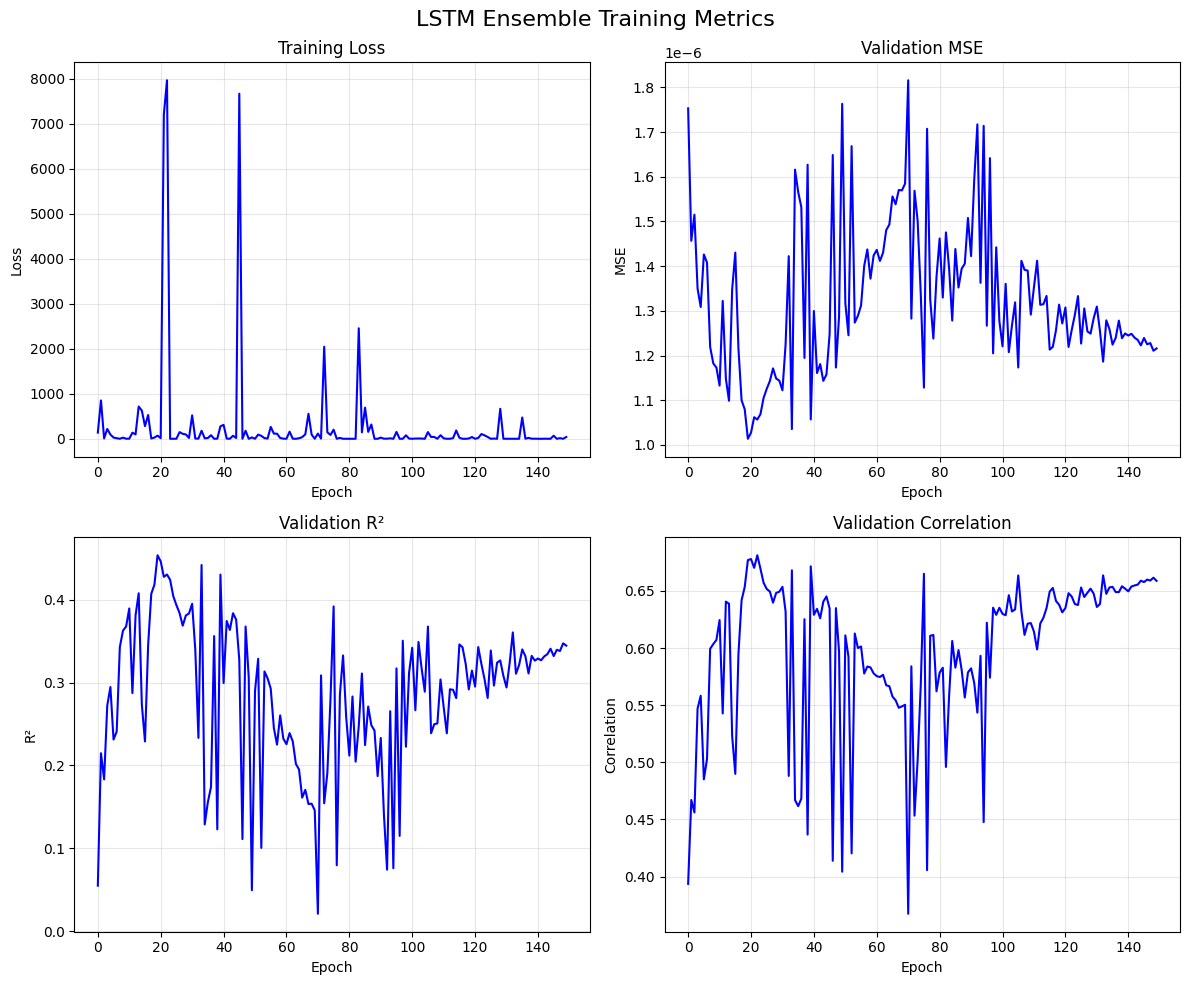

Research visualization saved:
  PNG: /content/models/ensemble_analysis.png
  EPS: /content/models/ensemble_analysis.eps
Saved model with fixed weights to /content/models/lung_fixed_weights_model.pth

=== FINAL MODEL COMPARISON ===
Ensemble model:     R² = 0.3445362, MSE = 0.00000122
Two-stage model:    R² = 0.3732748, MSE = 0.00000116
Trend model:        R² = 0.2817221, MSE = 0.00000133
Ultra ensemble:     R² = 0.4999814, MSE = 0.00000093
Final weights used: [0.4, 0.2, 0.4]

PROCESS COMPLETED

Final Ultra Ensemble Model Summary:
Final MSE: 0.00000093
Final MAE: 0.00062502
Final R²: 0.4999814
Final Correlation: 0.7090
Final Weights: [0.4, 0.2, 0.4]

Visualization saved as:
  - /content/models/ensemble_analysis.png (for viewing)
  - /content/models/ensemble_analysis.eps (for publication)

Model saved as:
  - /content/models/lung_fixed_weights_model.pth


In [4]:
import os
import torch
import numpy as np
import random
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import RobustScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model_type = "lung"

os.makedirs('/content/models', exist_ok=True)

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

class R2Loss(nn.Module):
    def __init__(self, eps=1e-6):
        super(R2Loss, self).__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        if torch.isnan(y_pred).any() or torch.isnan(y_true).any():
            y_pred = torch.nan_to_num(y_pred, nan=0.0)
            y_true = torch.nan_to_num(y_true, nan=0.0)

        ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2) + self.eps
        ss_res = torch.sum((y_true - y_pred) ** 2) + self.eps
        r2 = 1 - ss_res / ss_tot
        return -r2

class WeightedR2MSELoss(nn.Module):
    def __init__(self, r2_weight=0.8, mse_weight=0.2, eps=1e-6):
        super(WeightedR2MSELoss, self).__init__()
        self.r2_weight = r2_weight
        self.mse_weight = mse_weight
        self.r2_loss = R2Loss(eps=eps)
        self.mse_loss = nn.MSELoss()

    def forward(self, y_pred, y_true):
        if torch.isnan(y_pred).any() or torch.isnan(y_true).any():
            y_pred = torch.nan_to_num(y_pred, nan=0.0)
            y_true = torch.nan_to_num(y_true, nan=0.0)

        r2 = self.r2_loss(y_pred, y_true)
        mse = self.mse_loss(y_pred, y_true)
        return self.r2_weight * r2 + self.mse_weight * mse

class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, output_size=1, bidirectional=False):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.dropout = nn.Dropout(dropout)
        self.attention = nn.Linear(hidden_size * (2 if bidirectional else 1), 1)
        self.fc1 = nn.Linear(hidden_size * (2 if bidirectional else 1), hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        if torch.isnan(x).any():
            x = torch.nan_to_num(x, nan=0.0)
        batch_size, seq_len, features = x.size()

        outputs, _ = self.lstm(x)

        attention_weights = F.softmax(self.attention(outputs), dim=1)
        context_vector = torch.sum(attention_weights * outputs, dim=1)

        x = F.gelu(self.fc1(context_vector))
        x = self.dropout(x)
        x = self.fc2(x)

        if torch.isnan(x).any():
            x = torch.nan_to_num(x, nan=0.0)

        return x

class EnsembleModel(nn.Module):
    def __init__(self, models, weights=None):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
        if weights is None:
            self.weights = nn.Parameter(torch.ones(len(models)) / len(models))
        else:
            self.weights = nn.Parameter(torch.tensor(weights, dtype=torch.float32))

    def forward(self, x):
        if torch.isnan(x).any():
            x = torch.nan_to_num(x, nan=0.0)

        outputs = []
        for model in self.models:
            output = model(x)
            outputs.append(output)

        stacked_outputs = torch.stack(outputs, dim=-1)

        weights = F.softmax(self.weights, dim=0)

        weighted_sum = torch.sum(stacked_outputs * weights, dim=-1)

        if torch.isnan(weighted_sum).any():
            weighted_sum = torch.nan_to_num(weighted_sum, nan=0.0)

        return weighted_sum

class TrendModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2):
        super(TrendModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)

        self.fc3 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn3 = nn.BatchNorm1d(hidden_size // 2)

        self.fc4 = nn.Linear(hidden_size // 2, output_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size = x.size(0)
        if torch.isnan(x).any():
            x = torch.nan_to_num(x, nan=0.0)
        if x.dim() > 2:
            x = x.reshape(batch_size, -1)
        x = self.fc1(x)
        if batch_size > 1:
            x = self.bn1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        identity = x
        x = self.fc2(x)
        if batch_size > 1:
            x = self.bn2(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = x + identity
        x = self.fc3(x)
        if batch_size > 1:
            x = self.bn3(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        if torch.isnan(x).any():
            x = torch.nan_to_num(x, nan=0.0)

        return x

class TimeSeries(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, noise_level=0.0):
        self.original_X = X.copy()
        self.original_y = y.reshape(-1, 1) if y.ndim == 1 else y.copy()

        self.x_scaler = RobustScaler(quantile_range=(5.0, 95.0))
        X_flat = np.nan_to_num(X.reshape(-1, X.shape[2]), nan=0.0)
        self.X_scaled = self.x_scaler.fit_transform(X_flat).reshape(X.shape)
        self.X_scaled = np.clip(self.X_scaled, -10.0, 10.0)

        self.y_scaler = RobustScaler(quantile_range=(5.0, 95.0))
        self.y_scaled = self.y_scaler.fit_transform(self.original_y)
        self.y_scaled = np.clip(self.y_scaled, -10.0, 10.0)

        self.noise_level = noise_level

    def __len__(self):
        return len(self.X_scaled)

    def __getitem__(self, idx):
        X_sample = self.X_scaled[idx].astype(np.float32)
        y_sample = self.y_scaled[idx].astype(np.float32)

        if self.noise_level > 0:
            noise = np.random.normal(0, self.noise_level, X_sample.shape)
            X_sample = X_sample + noise

        return torch.tensor(X_sample, dtype=torch.float32), torch.tensor(y_sample, dtype=torch.float32).view(-1)

    def inverse_transform_y(self, y_tensor):
        if hasattr(y_tensor, "detach"):
            y_numpy = y_tensor.detach().cpu().numpy()
        else:
            y_numpy = y_tensor
        return self.y_scaler.inverse_transform(y_numpy)

class TrendDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, scale_y: bool = True):
        assert X.shape[0] == y.shape[0], "Mismatched number of samples"
        self.original_X = X
        self.original_y = y.reshape(-1, 1) if y.ndim == 1 else y
        self.x_scaler = RobustScaler(quantile_range=(5.0, 95.0))
        X_flat = np.nan_to_num(X.reshape(-1, X.shape[2]), nan=0.0)
        X_scaled = self.x_scaler.fit_transform(X_flat).reshape(X.shape)
        X_scaled = np.clip(X_scaled, -10.0, 10.0)
        self.n, self.t, self.f = X.shape
        self.features = []
        self.targets = []
        self.indices = []
        for i in range(self.n):
            x_sample = X_scaled[i]
            y_sample = y[i]
            if np.isnan(x_sample).any() or np.isnan(y_sample):
                continue
            if self.t > 1:
                x_pct_change = np.zeros((self.t-1, self.f))
                for j in range(self.t-1):
                    denom = np.abs(x_sample[j]) + 1e-8
                    x_pct_change[j] = (x_sample[j+1] - x_sample[j]) / denom
                x_pct_change = np.clip(x_pct_change, -10.0, 10.0)
                x_combined = np.column_stack([
                    x_pct_change.reshape(-1),
                    x_sample[:-1].reshape(-1)
                ])

                self.features.append(x_combined)
                self.targets.append(y_sample)
                self.indices.append(i)

        if len(self.features) > 0:
            self.features = np.array(self.features)
            self.targets = np.array(self.targets).reshape(-1, 1)
            self.indices = np.array(self.indices)
            self.scale_y = scale_y
            if scale_y:
                self.y_scaler = RobustScaler(quantile_range=(5.0, 95.0))
                self.targets_scaled = self.y_scaler.fit_transform(self.targets)
                self.targets_scaled = np.clip(self.targets_scaled, -10.0, 10.0)
            else:
                self.targets_scaled = self.targets
                self.y_scaler = None
        else:
            print("Warning: No valid samples found for trend dataset")
            self.features = np.zeros((1, 1, self.f * 2))
            self.targets = np.zeros((1, 1))
            self.targets_scaled = np.zeros((1, 1))
            self.indices = np.zeros(1)
            self.scale_y = scale_y
            self.y_scaler = None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.features[idx], dtype=torch.float32),
            torch.tensor(self.targets_scaled[idx], dtype=torch.float32).view(-1)
        )

    def inverse_transform_y(self, y_tensor: torch.Tensor) -> np.ndarray:
        if self.scale_y and self.y_scaler is not None:
            return self.y_scaler.inverse_transform(y_tensor.detach().cpu().numpy())
        else:
            return y_tensor.detach().cpu().numpy()

def train(model, criterion, optimizer, train_dataloader, scheduler=None):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_dataloader:
        if torch.isnan(batch_X).any() or torch.isnan(batch_y).any():
            batch_X = torch.nan_to_num(batch_X, nan=0.0)
            batch_y = torch.nan_to_num(batch_y, nan=0.0)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()

    if scheduler is not None:
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(epoch_loss / len(train_dataloader))
        else:
            scheduler.step()
    return epoch_loss / len(train_dataloader)

def validate(model, val_dataloader, dataset):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in val_dataloader:
            if torch.isnan(batch_X).any() or torch.isnan(batch_y).any():
                batch_X = torch.nan_to_num(batch_X, nan=0.0)
                batch_y = torch.nan_to_num(batch_y, nan=0.0)
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            if torch.isnan(outputs).any():
                outputs = torch.nan_to_num(outputs, nan=0.0)
            all_targets.append(batch_y.cpu())
            all_preds.append(outputs.cpu())
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    all_preds = torch.nan_to_num(all_preds, nan=0.0)
    all_targets = torch.nan_to_num(all_targets, nan=0.0)
    np_preds = all_preds.numpy()
    np_targets = all_targets.numpy()
    mse = mean_squared_error(np_targets, np_preds)
    mae = mean_absolute_error(np_targets, np_preds)
    r2 = r2_score(np_targets, np_preds)
    try:
        corr = np.corrcoef(np_targets.flatten(), np_preds.flatten())[0, 1]
    except:
        corr = 0.0
    y_pred = dataset.inverse_transform_y(all_preds)
    y_true = dataset.inverse_transform_y(all_targets)
    true_mse = mean_squared_error(y_true, y_pred)
    true_mae = mean_absolute_error(y_true, y_pred)
    true_r2 = r2_score(y_true, y_pred)

    return mse, mae, r2, corr, true_mse, true_mae, true_r2

def ultra_ensemble_predict(X_batch, ensemble_model, two_stage_model, trend_model, weights=None):
    """Combines predictions from all three models with fixed weights"""
    if weights is None:
        weights = [0.4, 0.2, 0.4]  # Fixed weights for lung model

    X_batch = X_batch.to(device)

    if weights[0] > 0:
        ensemble_model.eval()
        with torch.no_grad():
            ensemble_pred = ensemble_model(X_batch).cpu()
    else:
        ensemble_pred = torch.zeros((X_batch.size(0), 1), device='cpu')

    if weights[1] > 0:
        two_stage_model.eval()
        with torch.no_grad():
            two_stage_pred = two_stage_model(X_batch).cpu()
    else:
        two_stage_pred = torch.zeros((X_batch.size(0), 1), device='cpu')

    if weights[2] > 0:
        X_np = X_batch.cpu().numpy()
        n, t, f = X_np.shape
        trend_features = []

        for i in range(n):
            x_sample = X_np[i]
            if t > 1:
                x_pct_change = np.zeros((t-1, f))
                for j in range(t-1):
                    denom = np.abs(x_sample[j]) + 1e-8
                    x_pct_change[j] = (x_sample[j+1] - x_sample[j]) / denom
                x_pct_change = np.clip(x_pct_change, -10.0, 10.0)
                x_combined = np.column_stack([
                    x_pct_change.reshape(-1),
                    x_sample[:-1].reshape(-1)
                ])
                trend_features.append(x_combined)

        if len(trend_features) > 0:
            trend_features_tensor = torch.tensor(np.array(trend_features), dtype=torch.float32).to(device)
            trend_model.eval()
            with torch.no_grad():
                trend_pred = trend_model(trend_features_tensor).cpu()
        else:
            trend_pred = torch.zeros((X_batch.size(0), 1), device='cpu')
    else:
        trend_pred = torch.zeros((X_batch.size(0), 1), device='cpu')

    final_pred = (
        weights[0] * ensemble_pred +
        weights[1] * two_stage_pred +
        weights[2] * trend_pred
    )

    return final_pred

def create_ensemble_analysis_plot(ensemble_history, trend_history, final_results):
    """
    Create proper visualization for lung model approach showing training metrics
    """

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('LSTM Ensemble Training Metrics', fontsize=16)

    # Training Loss
    ax1.plot(ensemble_history['train_losses'], 'b-', linewidth=1.5)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)

    # Validation MSE
    ax2.plot(ensemble_history['val_mses'], 'b-', linewidth=1.5)
    ax2.set_title('Validation MSE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MSE')
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2.grid(True, alpha=0.3)

    # Validation R²
    ax3.plot(ensemble_history['val_r2s'], 'b-', linewidth=1.5)
    ax3.set_title('Validation R²')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('R²')
    ax3.grid(True, alpha=0.3)

    # Validation Correlation
    ax4.plot(ensemble_history['val_corrs'], 'b-', linewidth=1.5)
    ax4.set_title('Validation Correlation')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Correlation')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/models/ensemble_analysis.png', dpi=300, bbox_inches='tight')
    plt.savefig('/content/models/ensemble_analysis.eps', format='eps', dpi=300, bbox_inches='tight')
    plt.show()

    print("Research visualization saved:")
    print("  PNG: /content/models/ensemble_analysis.png")
    print("  EPS: /content/models/ensemble_analysis.eps")

def load_data():
    """Loads your data files"""
    features = np.load(f'/content/{model_type}_features.npy')
    targets = np.load(f'/content/{model_type}_target.npy')
    index = np.load(f'/content/{model_type}_index.npy')
    return features, targets, index

def reproduce_best_results():
    set_all_seeds(42)

    print(f"Loading data for {model_type} model...")
    features, targets, index = load_data()
    best_params = {
        'hidden_size': 160,
        'num_layers': 2,
        'dropout': 0.031836289148041416,
        'learning_rate': 0.001373724419481818,
        'batch_size': 8,
        'bidirectional': False,
        'weight_decay': 0.00037885697505593265,
        'r2_weight': 0.5242984525942258,
        'loss_type': 'weighted'

    }

    hidden_size = best_params['hidden_size']
    num_layers = best_params['num_layers']
    dropout = best_params['dropout']
    learning_rate = best_params['learning_rate']
    batch_size = best_params['batch_size']
    bidirectional = best_params['bidirectional']
    weight_decay = best_params['weight_decay']
    r2_weight = best_params['r2_weight']
    mse_weight = 1.0 - r2_weight
    loss_type = best_params['loss_type']

    X_train, X_test, y_train, y_test, _, index_test = train_test_split(
        features,
        targets,
        index,
        test_size=0.2,
        shuffle=True,
        stratify=index[:, 1],
        random_state=42
    )

    train_data = TimeSeries(X_train, y_train, noise_level=0.0001)
    test_data = TimeSeries(X_test, y_test, noise_level=0)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

    print("\nTraining ensemble model...")
    models = []
    for i in range(3):
        set_all_seeds(42 + i)
        h_size = int(hidden_size * (0.9 + 0.2 * np.random.random()))
        d_out = dropout * (0.8 + 0.4 * np.random.random())

        model = AttentionLSTM(
            input_size=features.shape[2],
            hidden_size=h_size,
            num_layers=num_layers,
            dropout=d_out,
            output_size=1,
            bidirectional=bidirectional
        ).to(device)

        models.append(model)

    set_all_seeds(42)
    ensemble_model = EnsembleModel(models, weights=[0.5, 0.3, 0.2]).to(device)

    if loss_type == "r2":
        criterion = R2Loss()
    else:
        criterion = WeightedR2MSELoss(r2_weight=r2_weight, mse_weight=mse_weight)

    optimizer = optim.AdamW(ensemble_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler1 = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10, verbose=False, min_lr=1e-6)
    scheduler2 = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=learning_rate/20)

    # Track metrics for plotting
    ensemble_train_losses = []
    ensemble_val_mses = []
    ensemble_val_maes = []
    ensemble_val_r2s = []
    ensemble_val_corrs = []

    num_epochs = 150
    for epoch in tqdm(range(num_epochs), desc="Training Ensemble"):
        train_loss = train(ensemble_model, criterion, optimizer, train_loader)
        scheduler2.step()
        mse, mae, r2, corr, true_mse, true_mae, true_r2 = validate(ensemble_model, test_loader, test_data)
        scheduler1.step(train_loss)

        # Store metrics
        ensemble_train_losses.append(train_loss)
        ensemble_val_mses.append(true_mse)
        ensemble_val_maes.append(true_mae)
        ensemble_val_r2s.append(true_r2)
        ensemble_val_corrs.append(corr)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.7f}, "
                  f"Val MSE: {true_mse:.8f}, Val MAE: {true_mae:.8f}, Val R²: {true_r2:.7f}, Val Corr: {corr:.7f}")

    _, _, _, _, ensemble_mse, ensemble_mae, ensemble_r2 = validate(ensemble_model, test_loader, test_data)
    print(f"Final Test MSE: {ensemble_mse:.8f}")
    print(f"Final Test R²: {ensemble_r2:.7f}")

    # Two-stage training with early stopping
    print("\nStarting two-stage training approach...")
    set_all_seeds(42)

    two_stage_model = AttentionLSTM(
        input_size=features.shape[2],
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        output_size=1,
        bidirectional=bidirectional
    ).to(device)

    # Stage 1: MSE Optimization with early stopping
    stage1_criterion = nn.MSELoss()
    stage1_optimizer = optim.Adam(two_stage_model.parameters(), lr=learning_rate, weight_decay=weight_decay/10)
    stage1_scheduler = ReduceLROnPlateau(stage1_optimizer, mode='min', factor=0.5, patience=5)

    print("Stage 1: MSE Optimization")
    stage1_epochs = 50
    best_mse = float('inf')
    best_stage1_state = None
    patience_counter = 0
    patience = 10

    for epoch in range(stage1_epochs):
        train_loss = train(two_stage_model, stage1_criterion, stage1_optimizer, train_loader, stage1_scheduler)
        mse, mae, r2, _, _, _, _ = validate(two_stage_model, test_loader, test_data)

        if mse < best_mse:
            best_mse = mse
            best_stage1_state = two_stage_model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f"Stage 1 - Epoch {epoch+1}/{stage1_epochs}, Train Loss: {train_loss:.7f}, Val MSE: {mse:.8f}, Val R²: {r2:.7f}")

        if patience_counter >= patience:
            print(f"Early stopping stage 1 at epoch {epoch+1}")
            break

    two_stage_model.load_state_dict(best_stage1_state)

    # Stage 2: R² Optimization with early stopping
    print("\nStage 2: R² Optimization")
    for name, param in two_stage_model.named_parameters():
        if 'lstm' in name or 'fc1' in name:
            param.requires_grad = False

    stage2_criterion = R2Loss()
    stage2_optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, two_stage_model.parameters()),
        lr=learning_rate / 5,
        weight_decay=weight_decay / 2
    )
    stage2_scheduler = CosineAnnealingWarmRestarts(stage2_optimizer, T_0=5, T_mult=2, eta_min=1e-6)

    stage2_epochs = 50
    best_r2 = -float('inf')
    best_stage2_state = None
    patience_counter = 0

    for epoch in range(stage2_epochs):
        train_loss = train(two_stage_model, stage2_criterion, stage2_optimizer, train_loader, stage2_scheduler)
        _, _, r2, _, true_mse, true_mae, true_r2 = validate(two_stage_model, test_loader, test_data)

        if true_r2 > best_r2:
            best_r2 = true_r2
            best_stage2_state = two_stage_model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 5 == 0:
            print(f"Stage 2 - Epoch {epoch+1}/{stage2_epochs}, Train Loss: {train_loss:.7f}, Val R²: {true_r2:.7f}, Val MSE: {true_mse:.8f}")

        if patience_counter >= patience:
            print(f"Early stopping stage 2 at epoch {epoch+1}")
            break

    two_stage_model.load_state_dict(best_stage2_state)

    _, _, _, _, two_stage_mse, two_stage_mae, two_stage_r2 = validate(two_stage_model, test_loader, test_data)
    print(f"\nTwo-Stage Model Results:")
    print(f"MSE: {two_stage_mse:.8f}")
    print(f"R²: {two_stage_r2:.7f}")

    # Trend model training with early stopping
    print("\nTraining trend-focused model...")
    set_all_seeds(42)

    trend_train_data = TrendDataset(X_train, y_train)
    trend_test_data = TrendDataset(X_test, y_test)
    input_dim = trend_train_data.features.shape[1] * trend_train_data.features.shape[2]
    trend_train_loader = DataLoader(trend_train_data, batch_size=32, shuffle=True, num_workers=0)
    trend_test_loader = DataLoader(trend_test_data, batch_size=32, shuffle=False, num_workers=0)

    trend_model = TrendModel(
        input_size=input_dim,
        hidden_size=128,
        output_size=1,
        dropout=0.2
    ).to(device)

    trend_criterion = R2Loss()
    trend_optimizer = optim.AdamW(trend_model.parameters(), lr=0.001, weight_decay=1e-5)
    trend_scheduler = ReduceLROnPlateau(trend_optimizer, mode='min', factor=0.5, patience=10, verbose=False)

    # Track trend model metrics
    trend_val_r2s = []
    trend_val_mses = []

    trend_epochs = 100
    best_trend_r2 = -float('inf')
    best_trend_state = None
    patience_counter = 0
    patience = 15

    for epoch in tqdm(range(trend_epochs), desc="Training Trend"):
        train_loss = train(trend_model, trend_criterion, trend_optimizer, trend_train_loader, trend_scheduler)

        if (epoch + 1) % 10 == 0:
            _, _, _, _, true_mse, true_mae, true_r2 = validate(trend_model, trend_test_loader, trend_test_data)
            trend_val_r2s.append(true_r2)
            trend_val_mses.append(true_mse)
            print(f"Trend Model - Epoch {epoch+1}/{trend_epochs}, Train Loss: {train_loss:.7f}, "
                  f"Val R²: {true_r2:.7f}, Val MSE: {true_mse:.8f}")

            if true_r2 > best_trend_r2:
                best_trend_r2 = true_r2
                best_trend_state = trend_model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping trend model at epoch {epoch+1}")
                break

    if best_trend_state is not None:
        trend_model.load_state_dict(best_trend_state)

    _, _, _, _, trend_mse, trend_mae, trend_r2 = validate(trend_model, trend_test_loader, trend_test_data)
    print(f"\nTrend Model Results:")
    print(f"MSE: {trend_mse:.8f}")
    print(f"R²: {trend_r2:.7f}")

    # Ultra ensemble with FIXED weights [0.4, 0.2, 0.4]
    print("\nCreating ultra ensemble solution with FIXED weights [0.4, 0.2, 0.4]...")
    ultra_weights = [0.4, 0.2, 0.4]  # Fixed weights as requested

    # Final evaluation with fixed weights
    all_preds = []
    all_targets = []

    for X_batch, y_batch in test_loader:
        pred = ultra_ensemble_predict(X_batch, ensemble_model, two_stage_model, trend_model, ultra_weights)
        all_preds.append(pred)
        all_targets.append(y_batch)

    y_pred_tensor = torch.cat(all_preds)
    y_true_tensor = torch.cat(all_targets)

    y_pred = test_data.inverse_transform_y(y_pred_tensor)
    y_true = test_data.inverse_transform_y(y_true_tensor)

    ultra_mse = mean_squared_error(y_true, y_pred)
    ultra_mae = mean_absolute_error(y_true, y_pred)
    ultra_r2 = r2_score(y_true, y_pred)
    ultra_corr = np.corrcoef(y_true.flatten(), y_pred.flatten())[0, 1]

    print("\nUltra Ensemble Final Results:")
    print(f"MSE: {ultra_mse:.8f}")
    print(f"MAE: {ultra_mae:.8f}")
    print(f"R²: {ultra_r2:.7f}")
    print(f"Correlation: {ultra_corr:.4f}")

    # Prepare data for visualization
    ensemble_history = {
        'train_losses': ensemble_train_losses,
        'val_mses': ensemble_val_mses,
        'val_maes': ensemble_val_maes,
        'val_r2s': ensemble_val_r2s,
        'val_corrs': ensemble_val_corrs
    }

    trend_history = {
        'val_r2s': trend_val_r2s,
        'val_mses': trend_val_mses
    }

    final_results = {
        'ensemble_mse': ensemble_mse,
        'ensemble_mae': ensemble_mae,
        'ensemble_r2': ensemble_r2,
        'two_stage_mse': two_stage_mse,
        'two_stage_mae': two_stage_mae,
        'two_stage_r2': two_stage_r2,
        'trend_mse': trend_mse,
        'trend_mae': trend_mae,
        'trend_r2': trend_r2,
        'ultra_mse': ultra_mse,
        'ultra_mae': ultra_mae,
        'ultra_r2': ultra_r2,
        'ultra_corr': ultra_corr
    }

    # Create the proper research visualization
    print("\nGenerating ensemble analysis visualization...")
    create_ensemble_analysis_plot(ensemble_history, trend_history, final_results)

    # Save the model with fixed results
    save_path = f"/content/models/{model_type}_fixed_weights_model.pth"
    torch.save({
        'ensemble_model': ensemble_model.state_dict(),
        'two_stage_model': two_stage_model.state_dict(),
        'trend_model': trend_model.state_dict(),
        'weights': ultra_weights,  # Fixed weights [0.4, 0.2, 0.4]
        'params': best_params,
        'performance': {'r2': ultra_r2, 'mse': ultra_mse, 'mae': ultra_mae, 'corr': ultra_corr},
        'training_history': {
            'ensemble': ensemble_history,
            'trend': trend_history,
            'final_results': final_results
        }
    }, save_path)

    print(f"Saved model with fixed weights to {save_path}")

    print("\n=== FINAL MODEL COMPARISON ===")
    print(f"Ensemble model:     R² = {ensemble_r2:.7f}, MSE = {ensemble_mse:.8f}")
    print(f"Two-stage model:    R² = {two_stage_r2:.7f}, MSE = {two_stage_mse:.8f}")
    print(f"Trend model:        R² = {trend_r2:.7f}, MSE = {trend_mse:.8f}")
    print(f"Ultra ensemble:     R² = {ultra_r2:.7f}, MSE = {ultra_mse:.8f}")
    print(f"Final weights used: {ultra_weights}")
    print("============================")

    return {
        'ensemble_model': ensemble_model,
        'two_stage_model': two_stage_model,
        'trend_model': trend_model,
        'weights': ultra_weights,
        'params': best_params,
        'performance': {'r2': ultra_r2, 'mse': ultra_mse, 'mae': ultra_mae, 'corr': ultra_corr},
        'training_history': {
            'ensemble': ensemble_history,
            'trend': trend_history,
            'final_results': final_results
        }
    }

if __name__ == "__main__":
    model_result = reproduce_best_results()
    print("\nPROCESS COMPLETED")
    print("\nFinal Ultra Ensemble Model Summary:")
    print("="*50)
    perf = model_result['performance']
    print(f"Final MSE: {perf['mse']:.8f}")
    print(f"Final MAE: {perf['mae']:.8f}")
    print(f"Final R²: {perf['r2']:.7f}")
    print(f"Final Correlation: {perf['corr']:.4f}")
    print(f"Final Weights: {model_result['weights']}")
    print("="*50)
    print("\nVisualization saved as:")
    print("  - /content/models/ensemble_analysis.png (for viewing)")
    print("  - /content/models/ensemble_analysis.eps (for publication)")
    print("\nModel saved as:")
    print(f"  - /content/models/{model_type}_fixed_weights_model.pth")